In [3]:
!pip install ..

Processing /home/nathan/workspace/transfer-style
  Created wheel for transferutils: filename=transferutils-0.0.1-cp36-none-any.whl size=5965 sha256=0967d3cdb33e9a3aef17221e497c485afb7844aa4b0872a43735175513e30c91
  Stored in directory: /home/nathan/.cache/pip/wheels/b8/97/a6/85e4f02f381d38fe0c42e053c3727b326b4c736667f55e65e7
Successfully built transferutils


In [14]:
from typing import Sequence, Tuple

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras as keras

from tensorflow.keras.applications import VGG19
from PIL import Image
from tqdm import tqdm

import transferutils as tu

STYLE_PATH = "../data/style"
CONTENT_PATH = "../data/content"

IMAGE_SHAPE = (512, 512, 3)

In [2]:
style_img = tu.import_transform(f"{STYLE_PATH}/vangogh.png")
content_img = tu.import_transform(f"{CONTENT_PATH}/ensc.png")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


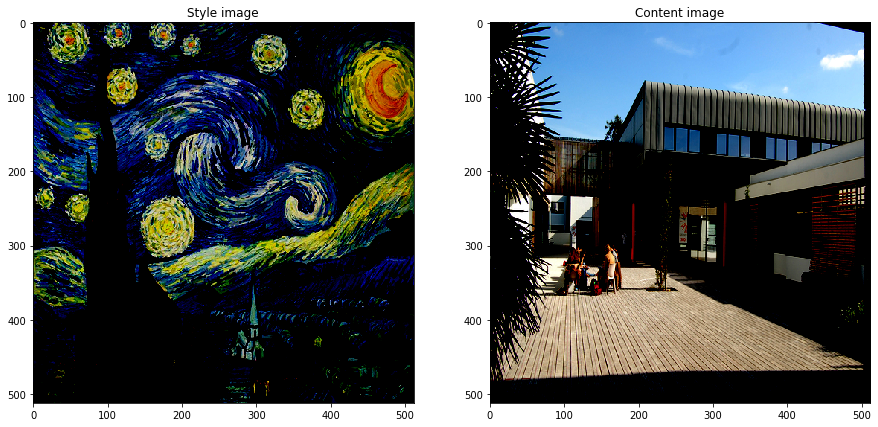

In [3]:
fig = plt.figure(figsize=(15, 10))

axes = fig.add_subplot(1, 2, 1)
axes.imshow(np.squeeze(style_img))
axes.set_title("Style image")

axes = fig.add_subplot(1, 2, 2)
axes.imshow(np.squeeze(content_img))
axes.set_title("Content image")

plt.show(fig)

In [4]:
vgg_max = VGG19(include_top=False,  weights='imagenet', input_shape=IMAGE_SHAPE)
vgg_max.trainable = False
vgg = tu.replace_max_by_average_pooling(vgg_max)
vgg.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 512, 512, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 512, 512, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 512, 512, 64)      36928     
_________________________________________________________________
block1_pool (AveragePooling2 (None, 256, 256, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 256, 256, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 256, 256, 128)     147584    
_________________________________________________________________
block2_pool (AveragePooling2 (None, 128, 128, 128)     0     

In [11]:
content_blocks = [tu.get_vgg_layer(vgg, f"block{i}_conv1", f"block{i}") for i in range(1, 6)]
style_blocks = [[content_blocks[j] for j in range(i)] for i in range(1, len(content_blocks) + 1)]

In [ ]:
def compute_loss(style_layers: Sequence[keras.models.Model],
                 content_layer: keras.model.Model,
                 init_noise: tf.Variable,
                 content_features: tf.Tensor,
                 style_features: tf.Tensor) -> tf.Tensor:
    